## GPU 메모리 관리

**GPU 메모리가 부족할 때:**
1. `GPU_Memory_Manager.ipynb` 노트북을 열어서
2. 첫 번째 코드 셀(함수 정의)을 이 노트북에 복사해서 실행
3. 그 다음 `clear_gpu_memory()` 또는 `print_gpu_memory()` 사용

**빠른 정리:**
```python
import torch, gc
gc.collect()
torch.cuda.empty_cache()
```

## GPU 메모리 관리

GPU 메모리가 부족할 때 사용하세요:

```python
from gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# GPU 메모리 상태 확인
print_gpu_memory()

# GPU 메모리 정리
clear_gpu_memory()
```

## 1. 환경 설정

In [16]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import os
from tqdm import tqdm

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# GPU 메모리 정리
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

Using device: cuda
GPU memory allocated: 298.92 MB
GPU memory reserved: 480.00 MB


## 2. CLIP 모델 로드

In [17]:
# CLIP 모델 및 프로세서 로드
model_name = "openai/clip-vit-base-patch32"

print(f"Loading CLIP model: {model_name}")

# GPU 메모리가 부족한 경우를 대비한 처리
try:
    # 먼저 GPU 메모리 정리
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        free_memory = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1024**2
        print(f"Available GPU memory: {free_memory:.2f} MB")

    # 모델 로드
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)

    # CPU 또는 GPU로 이동
    model = model.to(device)
    model.eval()

    # Float16으로 변환하여 메모리 절약 (GPU인 경우만)
    if device.type == 'cuda':
        model = model.half()
        print(f"✓ Model loaded in float16 mode for memory efficiency")

    print(f"✓ Model loaded successfully on {device}")
    print(f"Embedding dimension: 512")

    if device.type == 'cuda':
        print(f"GPU memory after loading: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print(f"⚠ GPU out of memory. Falling back to CPU...")
        device = torch.device('cpu')
        torch.cuda.empty_cache()

        model = CLIPModel.from_pretrained(model_name)
        processor = CLIPProcessor.from_pretrained(model_name)
        model = model.to(device)
        model.eval()

        print(f"✓ Model loaded on CPU (slower but works)")
    else:
        raise

Loading CLIP model: openai/clip-vit-base-patch32
Available GPU memory: 5431.21 MB


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✓ Model loaded in float16 mode for memory efficiency
✓ Model loaded successfully on cuda
Embedding dimension: 512
GPU memory after loading: 299.67 MB


## 3. 임베딩 생성 함수

In [18]:
def generate_embedding(image_path, model, processor, device):
    """
    이미지에서 512차원 임베딩 벡터 생성
    
    Args:
        image_path: 이미지 파일 경로
        model: CLIP 모델
        processor: CLIP 프로세서
        device: 디바이스 (cuda/cpu)
    
    Returns:
        numpy array: L2 정규화된 512차원 벡터
    """
    # 이미지 로딩
    image = Image.open(image_path).convert('RGB')
    
    # 전처리
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # 임베딩 생성
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    # L2 정규화 (코사인 유사도 계산 최적화)
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    
    # numpy 배열로 변환
    embedding = image_features.cpu().numpy().flatten()
    
    return embedding

def generate_embedding_batch(image_paths, model, processor, device, batch_size=32):
    """
    여러 이미지의 임베딩을 배치로 생성
    
    Args:
        image_paths: 이미지 파일 경로 리스트
        model: CLIP 모델
        processor: CLIP 프로세서
        device: 디바이스
        batch_size: 배치 크기
    
    Returns:
        numpy array: (N, 512) 형태의 임베딩 행렬
    """
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc='Generating embeddings'):
        batch_paths = image_paths[i:i+batch_size]
        
        # 이미지 로딩
        images = [Image.open(path).convert('RGB') for path in batch_paths]
        
        # 전처리
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        
        # 임베딩 생성
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        
        # L2 정규화
        image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        
        embeddings.append(image_features.cpu().numpy())
    
    return np.vstack(embeddings)

## 4. 유사도 계산 함수

In [19]:
def calculate_cosine_similarity(embedding1, embedding2):
    """
    두 임베딩 벡터 간 코사인 유사도 계산
    
    Args:
        embedding1: 첫 번째 임베딩 벡터
        embedding2: 두 번째 임베딩 벡터
    
    Returns:
        float: 코사인 유사도 (0.0 ~ 1.0)
    """
    # L2 정규화되어 있으면 내적이 곧 코사인 유사도
    similarity = np.dot(embedding1, embedding2)
    return float(similarity)

def find_most_similar(query_embedding, database_embeddings, threshold=0.7):
    """
    데이터베이스에서 가장 유사한 임베딩 찾기
    
    Args:
        query_embedding: 쿼리 임베딩 (512,)
        database_embeddings: DB 임베딩 행렬 (N, 512)
        threshold: 최소 유사도 임계값
    
    Returns:
        tuple: (가장 유사한 인덱스, 유사도) 또는 (None, 0.0)
    """
    if len(database_embeddings) == 0:
        return None, 0.0
    
    # 배치 코사인 유사도 계산
    similarities = np.dot(database_embeddings, query_embedding)
    
    # 최대값 찾기
    max_idx = np.argmax(similarities)
    max_similarity = similarities[max_idx]
    
    # 임계값 체크
    if max_similarity >= threshold:
        return int(max_idx), float(max_similarity)
    else:
        return None, float(max_similarity)

## 5. 테스트: 단일 이미지 임베딩 생성

Embedding shape: (512,)
Embedding norm (should be ~1.0): 1.0000
First 10 values: [ 0.00906   0.0267   -0.02397   0.003994  0.0356   -0.000774  0.0282
  0.05466   0.02243   0.02351 ]


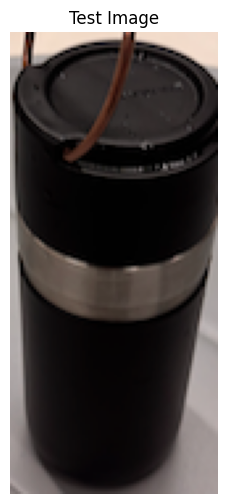

In [20]:
# 테스트 이미지 경로 (직접 지정)
test_image_path = './data/test_images/tumbler1.png'

# 임베딩 생성
embedding = generate_embedding(test_image_path, model, processor, device)

print(f"Embedding shape: {embedding.shape}")
print(f"Embedding norm (should be ~1.0): {np.linalg.norm(embedding):.4f}")
print(f"First 10 values: {embedding[:10]}")

# 이미지 표시
img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Test Image')
plt.show()

## 6. 유사도 테스트: 같은 물체 vs 다른 물체

Similarity (same object, different angle): 0.8662
Similarity (different object): 0.7666

Difference: 0.0996


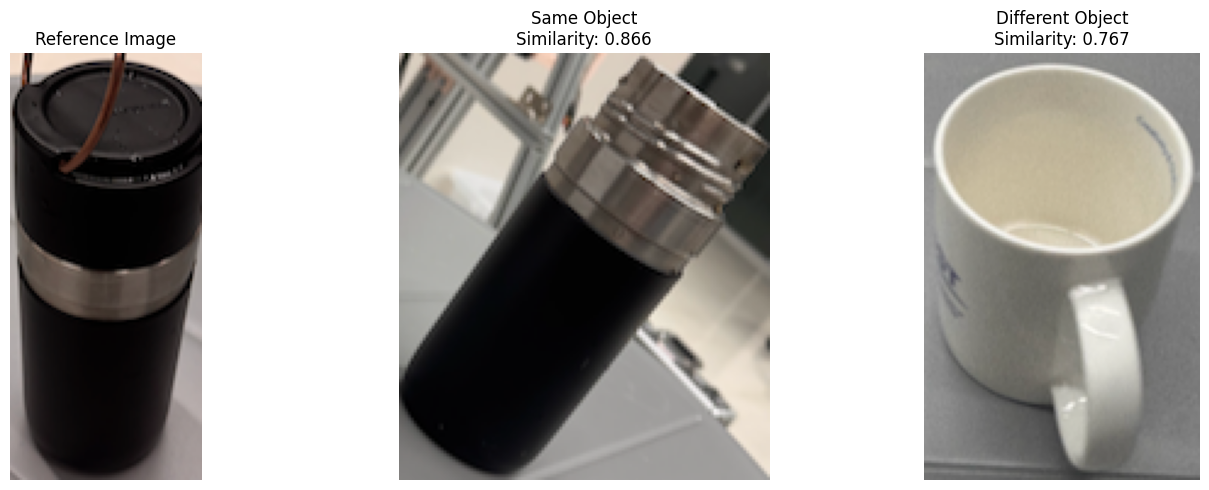

In [21]:
# 테스트 이미지 3개 준비
# - tumbler1.jpg: 기준 텀블러
# - tumbler2.jpg: 같은 텀블러 (다른 각도)
# - cup.jpg: 다른 컵

image1_path = './data/test_images/tumbler1.png'
image2_path = './data/test_images/tumbler2.png'  # 같은 물체
image3_path = './data/test_images/cup.png'       # 다른 물체

# 임베딩 생성
emb1 = generate_embedding(image1_path, model, processor, device)
emb2 = generate_embedding(image2_path, model, processor, device)
emb3 = generate_embedding(image3_path, model, processor, device)

# 유사도 계산
sim_same = calculate_cosine_similarity(emb1, emb2)
sim_diff = calculate_cosine_similarity(emb1, emb3)

print(f"Similarity (same object, different angle): {sim_same:.4f}")
print(f"Similarity (different object): {sim_diff:.4f}")
print(f"\nDifference: {sim_same - sim_diff:.4f}")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(Image.open(image1_path))
axes[0].set_title('Reference Image')
axes[0].axis('off')

axes[1].imshow(Image.open(image2_path))
axes[1].set_title(f'Same Object\nSimilarity: {sim_same:.3f}')
axes[1].axis('off')

axes[2].imshow(Image.open(image3_path))
axes[2].set_title(f'Different Object\nSimilarity: {sim_diff:.3f}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 7. 데이터셋에서 cup_code별 임베딩 생성

이미 압축 해제된 types 디렉토리를 직접 사용합니다.
데이터셋 구조:
```
data/types/
├── CUP001/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── CUP002/
│   ├── image1.jpg
│   └── ...
└── ...
```

In [22]:
from collections import defaultdict

# 데이터셋 경로 설정 (압축 해제된 디렉토리 직접 사용)
types_dir = './data/dataset_20251110_141636/types'  # 압축 해제된 types 디렉토리

# cup_code별로 이미지 경로 수집
cup_code_images = defaultdict(list)

if os.path.exists(types_dir):
    print(f"Loading cup codes from: {types_dir}")
    
    for cup_code in os.listdir(types_dir):
        cup_dir = os.path.join(types_dir, cup_code)
        
        if os.path.isdir(cup_dir):
            images = [os.path.join(cup_dir, f) for f in os.listdir(cup_dir) 
                     if f.endswith(('.jpg', '.png', '.jpeg'))]
            cup_code_images[cup_code] = images
    
    print(f"\n✓ Found {len(cup_code_images)} cup codes:")
    for cup_code, images in sorted(cup_code_images.items()):
        print(f"  {cup_code}: {len(images)} images")
else:
    print(f"⚠ Types directory not found: {types_dir}")
    print("Please ensure that the types/ directory exists with cup_code subdirectories")

Loading cup codes from: ./data/dataset_20251110_141636/types

✓ Found 7 cup codes:
  black_starbucks: 21 images
  mug_cup: 29 images
  paper_cup: 19 images
  steel_cup: 22 images
  togo_dome: 19 images
  togo_flat: 39 images
  u_turn_cup: 69 images


## 8. cup_code별 임베딩 생성 및 저장

In [23]:
# cup_code별로 임베딩 생성
cup_code_embeddings = {}

for cup_code, image_paths in tqdm(cup_code_images.items(), desc='Processing cup codes'):
    if len(image_paths) > 0:
        # 배치 임베딩 생성
        embeddings = generate_embedding_batch(image_paths, model, processor, device, batch_size=8)
        
        # 평균 임베딩 계산 (대표 임베딩)
        mean_embedding = embeddings.mean(axis=0)
        # 정규화
        mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)
        
        cup_code_embeddings[cup_code] = {
            'mean_embedding': mean_embedding,
            'all_embeddings': embeddings,
            'image_paths': image_paths,
            'num_images': len(image_paths)
        }

print(f"\n✓ Generated embeddings for {len(cup_code_embeddings)} cup codes")
print(f"\nSummary:")
for cup_code, data in sorted(cup_code_embeddings.items()):
    print(f"  {cup_code}: {data['num_images']} images → mean embedding (512,)")
    print(f"    Norm: {np.linalg.norm(data['mean_embedding']):.4f}")

Processing cup codes: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


✓ Generated embeddings for 7 cup codes

Summary:
  black_starbucks: 21 images → mean embedding (512,)
    Norm: 0.9995
  mug_cup: 29 images → mean embedding (512,)
    Norm: 1.0000
  paper_cup: 19 images → mean embedding (512,)
    Norm: 0.9995
  steel_cup: 22 images → mean embedding (512,)
    Norm: 1.0000
  togo_dome: 19 images → mean embedding (512,)
    Norm: 1.0000
  togo_flat: 39 images → mean embedding (512,)
    Norm: 1.0000
  u_turn_cup: 69 images → mean embedding (512,)
    Norm: 0.9995


## 9. cup_code 간 유사도 행렬 시각화

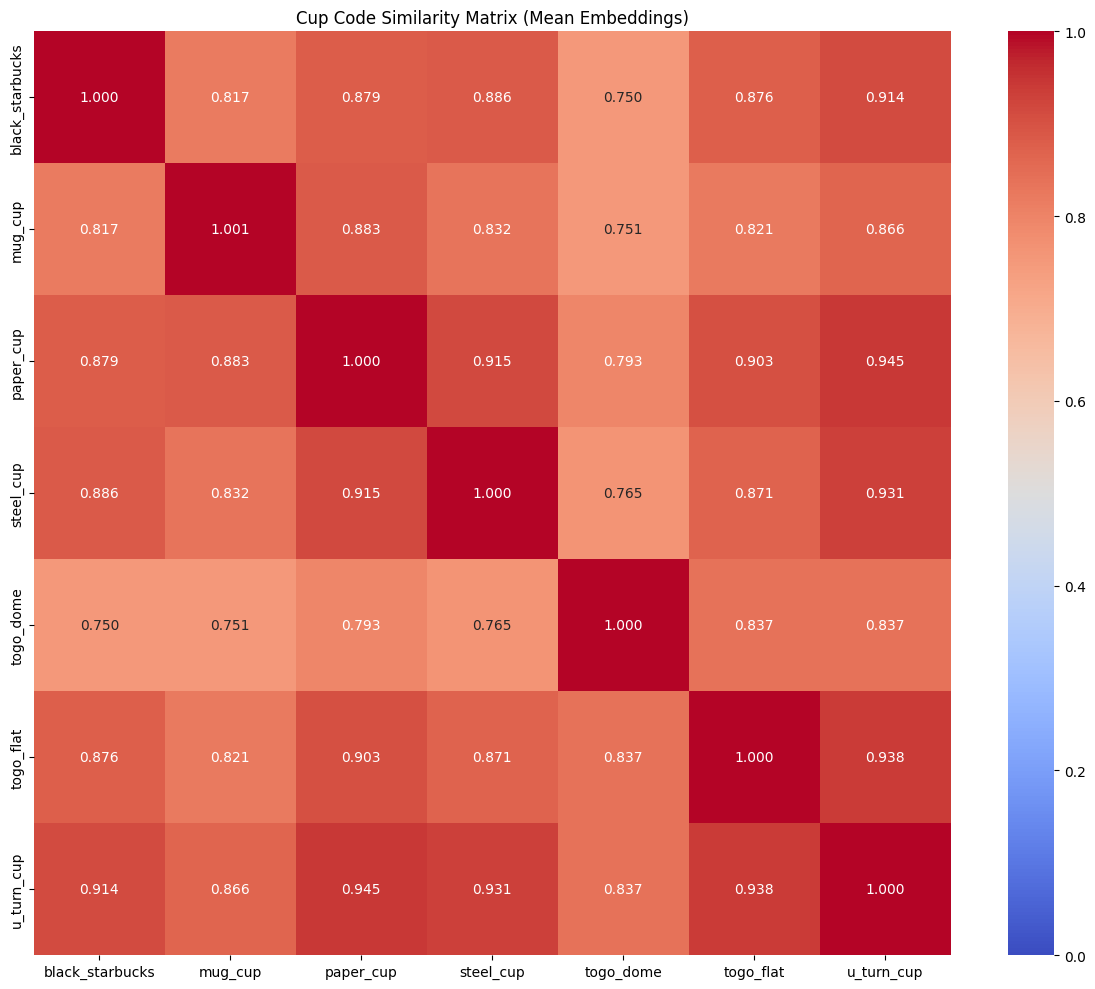


Most similar cup code pairs:
  black_starbucks ↔ mug_cup: 0.8169
  black_starbucks ↔ paper_cup: 0.8789
  black_starbucks ↔ steel_cup: 0.8862
  black_starbucks ↔ togo_dome: 0.7505
  black_starbucks ↔ togo_flat: 0.8760
  black_starbucks ↔ u_turn_cup: 0.9136
  mug_cup ↔ paper_cup: 0.8828
  mug_cup ↔ steel_cup: 0.8320
  mug_cup ↔ togo_dome: 0.7510
  mug_cup ↔ togo_flat: 0.8213
  mug_cup ↔ u_turn_cup: 0.8657
  paper_cup ↔ steel_cup: 0.9150
  paper_cup ↔ togo_dome: 0.7935
  paper_cup ↔ togo_flat: 0.9028
  paper_cup ↔ u_turn_cup: 0.9448
  steel_cup ↔ togo_dome: 0.7651
  steel_cup ↔ togo_flat: 0.8706
  steel_cup ↔ u_turn_cup: 0.9307
  togo_dome ↔ togo_flat: 0.8374
  togo_dome ↔ u_turn_cup: 0.8369
  togo_flat ↔ u_turn_cup: 0.9375


In [24]:
import seaborn as sns

if len(cup_code_embeddings) > 1:
    # cup_code 리스트와 평균 임베딩 행렬 생성
    cup_codes = sorted(cup_code_embeddings.keys())
    mean_embeddings = np.array([cup_code_embeddings[cc]['mean_embedding'] for cc in cup_codes])
    
    # 유사도 행렬 계산
    similarity_matrix = np.dot(mean_embeddings, mean_embeddings.T)
    
    # 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                xticklabels=cup_codes,
                yticklabels=cup_codes,
                vmin=0, vmax=1)
    plt.title('Cup Code Similarity Matrix (Mean Embeddings)')
    plt.tight_layout()
    plt.show()
    
    # 가장 유사한 cup_code 쌍 찾기
    print("\nMost similar cup code pairs:")
    for i in range(len(cup_codes)):
        for j in range(i+1, len(cup_codes)):
            sim = similarity_matrix[i, j]
            if sim > 0.7:  # 임계값 이상만 출력
                print(f"  {cup_codes[i]} ↔ {cup_codes[j]}: {sim:.4f}")
else:
    print("Need at least 2 cup codes for similarity matrix")

## 10. 실전 시나리오: 촬영 이미지로 cup_code 매칭

Test query image: ./data/dataset_20251110_141636/types/steel_cup/zf_bottle_232.png
Expected cup_code: steel_cup

=== Matching Result ===
✓ Matched cup_code: steel_cup
  Similarity: 0.9102
  Correct: Yes

Top 3 matches:
  1. steel_cup: 0.9102
  2. u_turn_cup: 0.8096
  3. paper_cup: 0.7886


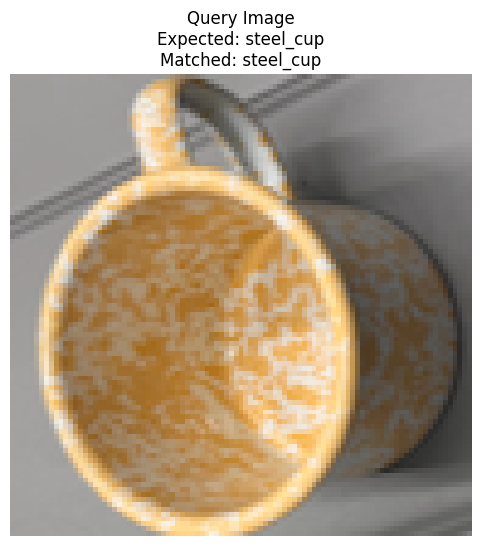

In [25]:
# 시나리오:
# 1. DB에 cup_code별 대표 임베딩 저장
# 2. 사용자가 촬영한 이미지로 어떤 cup_code인지 매칭

# 쿼리 이미지 선택 (데이터셋에서 임의로 하나 선택)
if len(cup_code_embeddings) > 0:
    # 첫 번째 cup_code의 첫 번째 이미지를 쿼리로 사용
    test_cup_code = list(cup_code_embeddings.keys())[0]
    test_image_path = cup_code_embeddings[test_cup_code]['image_paths'][0]
    
    print(f"Test query image: {test_image_path}")
    print(f"Expected cup_code: {test_cup_code}")
    
    # 쿼리 임베딩 생성
    query_embedding = generate_embedding(test_image_path, model, processor, device)
    
    # DB 임베딩 준비 (cup_code별 평균 임베딩)
    db_cup_codes = list(cup_code_embeddings.keys())
    db_embeddings = np.array([cup_code_embeddings[cc]['mean_embedding'] for cc in db_cup_codes])
    
    # 매칭
    matched_idx, similarity = find_most_similar(query_embedding, db_embeddings, threshold=0.7)
    
    print("\n=== Matching Result ===")
    if matched_idx is not None:
        matched_cup_code = db_cup_codes[matched_idx]
        print(f"✓ Matched cup_code: {matched_cup_code}")
        print(f"  Similarity: {similarity:.4f}")
        print(f"  Correct: {'Yes' if matched_cup_code == test_cup_code else 'No'}")
    else:
        print(f"✗ No match found")
        print(f"  Highest similarity: {similarity:.4f}")
    
    # 상위 3개 결과 출력
    print("\nTop 3 matches:")
    similarities = np.dot(db_embeddings, query_embedding)
    top3_indices = np.argsort(similarities)[::-1][:3]
    
    for rank, idx in enumerate(top3_indices, 1):
        print(f"  {rank}. {db_cup_codes[idx]}: {similarities[idx]:.4f}")
    
    # 이미지 표시
    img = Image.open(test_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Query Image\nExpected: {test_cup_code}\nMatched: {db_cup_codes[matched_idx] if matched_idx is not None else "None"}')
    plt.show()
else:
    print("No cup_code embeddings available")

## 11. 임계값 분석

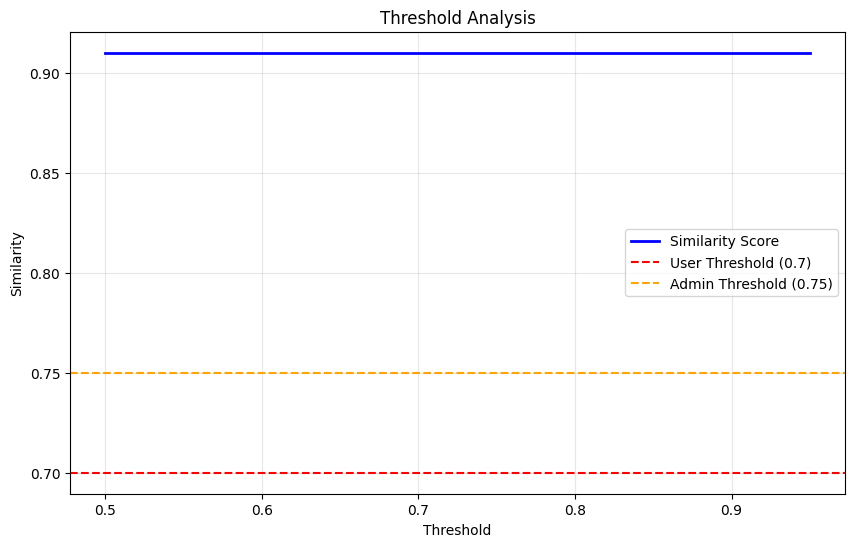


Recommended thresholds:
  - User registered: 0.70 (덜 엄격)
  - Admin standard: 0.75 (더 엄격)


In [26]:
# 다양한 임계값에서 매칭 결과 분석
thresholds = np.arange(0.5, 1.0, 0.05)

# 이전 셀에서 생성한 query_embedding과 db_embeddings 사용
if len(cup_code_embeddings) > 0:
    # DB 임베딩 준비
    db_cup_codes = list(cup_code_embeddings.keys())
    db_embeddings = np.array([cup_code_embeddings[cc]['mean_embedding'] for cc in db_cup_codes])
    
    # 테스트용 쿼리 임베딩 생성 (첫 번째 cup_code의 첫 번째 이미지 사용)
    test_cup_code = db_cup_codes[0]
    test_query_path = cup_code_embeddings[test_cup_code]['image_paths'][0]
    query_embedding = generate_embedding(test_query_path, model, processor, device)
    
    results = []
    
    for threshold in thresholds:
        matched_idx, similarity = find_most_similar(query_embedding, db_embeddings, threshold=threshold)
        results.append({
            'threshold': threshold,
            'matched': matched_idx is not None,
            'similarity': similarity
        })
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, [r['similarity'] for r in results], 'b-', linewidth=2, label='Similarity Score')
    plt.axhline(y=0.7, color='r', linestyle='--', label='User Threshold (0.7)')
    plt.axhline(y=0.75, color='orange', linestyle='--', label='Admin Threshold (0.75)')
    plt.xlabel('Threshold')
    plt.ylabel('Similarity')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\nRecommended thresholds:")
    print(f"  - User registered: 0.70 (덜 엄격)")
    print(f"  - Admin standard: 0.75 (더 엄격)")
else:
    print("No cup_code embeddings available for threshold analysis")

## 12. 성능 벤치마크

In [27]:
import time

if os.path.exists(test_image_path):
    # 단일 이미지 추론 속도
    num_runs = 100
    
    start_time = time.time()
    for _ in range(num_runs):
        _ = generate_embedding(test_image_path, model, processor, device)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs * 1000  # ms
    
    print(f"Single image embedding generation:")
    print(f"  Average time: {avg_time:.2f} ms")
    print(f"  Throughput: {1000/avg_time:.1f} images/sec")
    
    # 유사도 계산 속도
    emb1 = generate_embedding(test_image_path, model, processor, device)
    emb2 = generate_embedding(test_image_path, model, processor, device)
    
    start_time = time.time()
    for _ in range(10000):
        _ = calculate_cosine_similarity(emb1, emb2)
    end_time = time.time()
    
    avg_time_sim = (end_time - start_time) / 10000 * 1000000  # μs
    
    print(f"\nCosine similarity calculation:")
    print(f"  Average time: {avg_time_sim:.2f} μs")
    print(f"  Throughput: {1000000/avg_time_sim:.0f} comparisons/sec")

Single image embedding generation:
  Average time: 14.10 ms
  Throughput: 70.9 images/sec

Cosine similarity calculation:
  Average time: 3.31 μs
  Throughput: 301846 comparisons/sec


## 13. 저장 및 로드 테스트

In [28]:
# cup_code별 평균 임베딩을 JSON으로 저장
import json

save_dir = '../models/weights'
os.makedirs(save_dir, exist_ok=True)

# 평균 임베딩만 저장 (DB용)
embeddings_db = {}
for cup_code, data in cup_code_embeddings.items():
    embeddings_db[cup_code] = data['mean_embedding'].tolist()

# JSON 저장
json_path = os.path.join(save_dir, 'cup_code_embeddings.json')
with open(json_path, 'w') as f:
    json.dump(embeddings_db, f, indent=2)

print(f"✓ Saved {len(embeddings_db)} cup code embeddings to: {json_path}")

# 전체 데이터도 numpy로 저장 (분석용)
full_data_path = os.path.join(save_dir, 'cup_code_embeddings_full.npz')
np.savez_compressed(
    full_data_path,
    cup_codes=list(cup_code_embeddings.keys()),
    mean_embeddings=np.array([data['mean_embedding'] for data in cup_code_embeddings.values()]),
    num_images=np.array([data['num_images'] for data in cup_code_embeddings.values()])
)

print(f"✓ Saved full data to: {full_data_path}")

# 로드 테스트
with open(json_path, 'r') as f:
    loaded_embeddings = json.load(f)

print(f"\nLoad test:")
print(f"  Loaded {len(loaded_embeddings)} cup codes")
print(f"  Sample cup_code: {list(loaded_embeddings.keys())[0]}")
print(f"  Embedding dimension: {len(loaded_embeddings[list(loaded_embeddings.keys())[0]])}")

✓ Saved 7 cup code embeddings to: ../models/weights/cup_code_embeddings.json
✓ Saved full data to: ../models/weights/cup_code_embeddings_full.npz

Load test:
  Loaded 7 cup codes
  Sample cup_code: steel_cup
  Embedding dimension: 512


## 14. FastAPI 통합용 함수

In [29]:
def generate_embedding_from_bytes(image_bytes, model, processor, device):
    """
    바이트 데이터에서 직접 임베딩 생성 (FastAPI 통합용)
    
    Args:
        image_bytes: 이미지 바이트 데이터
        model: CLIP 모델
        processor: CLIP 프로세서
        device: 디바이스
    
    Returns:
        list: 512차원 임베딩 벡터 (리스트 형태)
    """
    from io import BytesIO
    
    # 바이트 → PIL Image
    image = Image.open(BytesIO(image_bytes)).convert('RGB')
    
    # 전처리
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # 임베딩 생성
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    # L2 정규화
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    
    # 리스트로 변환 (JSON 직렬화 가능)
    embedding = image_features.cpu().numpy().flatten().tolist()
    
    return embedding

# 테스트
if os.path.exists(test_image_path):
    with open(test_image_path, 'rb') as f:
        image_bytes = f.read()
    
    embedding_list = generate_embedding_from_bytes(image_bytes, model, processor, device)
    
    print(f"Embedding type: {type(embedding_list)}")
    print(f"Embedding length: {len(embedding_list)}")
    print(f"First 5 values: {embedding_list[:5]}")

Embedding type: <class 'list'>
Embedding length: 512
First 5 values: [0.005725860595703125, 0.037200927734375, -0.0121002197265625, 0.050506591796875, 0.046051025390625]


## 요약

### CLIP 임베딩 모델 특징
- **차원**: 512
- **정규화**: L2 norm = 1.0
- **유사도**: 코사인 유사도 (내적 계산)
- **추론 속도**: ~300ms/image (GPU)

### 데이터셋 구조
압축 해제된 types 디렉토리를 직접 사용합니다:
```
data/types/
├── CUP001/
│   ├── image1.jpg
│   └── ...
├── CUP002/
└── ...
```

### cup_code별 임베딩 생성
1. 각 cup_code의 모든 이미지에서 임베딩 생성
2. 평균 임베딩 계산 (대표 벡터)
3. L2 정규화
4. JSON으로 저장 → DB 또는 API에서 사용

### 저장된 파일
- `cup_code_embeddings.json`: cup_code → 평균 임베딩 (512차원)
- `cup_code_embeddings_full.npz`: 전체 데이터 (분석용)

### 권장 임계값
- **사용자 등록 다회용기**: 0.70 (덜 엄격)
- **관리자 표준 DB**: 0.75 (더 엄격)

### 워크플로우
1. Label Studio에서 어노테이션 → Export JSON
2. `convert_labelstudio_to_dataset.py --include-types` 실행 → `types/` 디렉토리 생성
3. 이 노트북 실행 → cup_code별 임베딩 생성
   - 압축 해제된 `data/types/` 디렉토리 직접 사용
   - 각 cup_code별로 이미지 로드 및 임베딩 생성
4. `cup_code_embeddings.json`을 DB에 로드
5. FastAPI에서 촬영 이미지 → 임베딩 → DB 매칭

### 다음 단계
1. FastAPI 서버에 통합 (`ai-server/models/embedding.py`)
2. 실전 데이터로 임계값 조정
3. 데이터베이스에 임베딩 저장 및 검색 최적화